In [86]:
# Add project path to the PYTHONPATH

import os
import sys
import numpy as np
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [87]:
import pickle

In [88]:
from time import time

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [90]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

## Load Test Set

Load the test dataset

In [91]:
from nlp.dataset import Dataset

In [92]:
dataset = Dataset('/home/rmohashi/hd/sentiment140/test_data.csv')
dataset.load()
dataset.preprocess_texts(stemming=True)
data = dataset.cleaned_data.copy()

Time to clean up: 0.11 sec


In [93]:
x_test = data.text
y_test = data.label.astype('int')

In [94]:
import seaborn as sns

In [95]:
labeled_data = data.copy()
labeled_data.label = data.label.apply(lambda x: "positivo" if x == 4 else "negativo")

[Text(0, 0.5, 'Número de tweets'), Text(0.5, 0, 'Rótulo')]

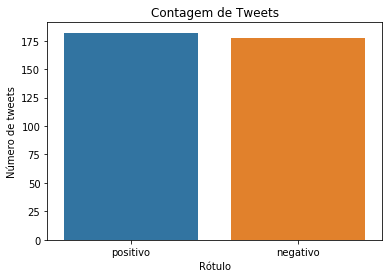

In [96]:
ax = sns.countplot(x='label', data=labeled_data)
ax.set_title('Contagem de Tweets')
ax.set(xlabel='Rótulo', ylabel='Número de tweets')

## Load Model

Load the trained naive bayes - sentiment analysis model

In [97]:
filepath = Path('../models/sentiment_analysis/nb_model.pickle').resolve()
with filepath.open('rb') as file:
    model = pickle.load(file)

## Naive Bayes

In [98]:
from sklearn.metrics import classification_report

In [99]:
results = model.predict(x_test)
print(classification_report(y_test, results, digits=4))

              precision    recall  f1-score   support

           0     0.8012    0.7740    0.7874       177
           4     0.7872    0.8132    0.8000       182

    accuracy                         0.7939       359
   macro avg     0.7942    0.7936    0.7937       359
weighted avg     0.7941    0.7939    0.7938       359



Confusion matrix
[[0.7740113  0.2259887 ]
 [0.18681319 0.81318681]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59c1e7b8d0>)

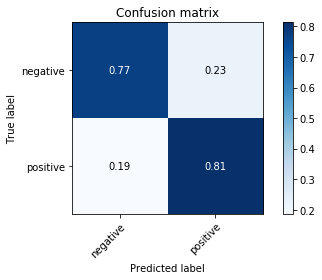

In [100]:
nb_y_test = y_test.apply(lambda x: 1 if x == 4 else 0)
nb_results = np.where(results != 4, results, 1)
classes = np.array(['negative', 'positive'])
plot_confusion_matrix(nb_y_test, nb_results, classes, normalize=True)

## Neural Networks

In [101]:
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [102]:
from sentiment_analysis.models.lstm_model import lstm_model
from sentiment_analysis.models.cnn_model import cnn_model
from sentiment_analysis.models.lstm_conv_model import lstm_conv_model

In [103]:
tokenizer_path = Path('/home/rmohashi/hd/emotion/tokenizer.pickle').resolve()

In [104]:
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

In [105]:
sequences = [text.split() for text in data.text]
list_tokenized = tokenizer.texts_to_sequences(sequences)

In [106]:
y_test = data.label.replace(4, 1)

### 100d - W2V

In [139]:
input_dim = len(tokenizer.word_index) + 1

In [140]:
input_length = 30
embedding_dim = 100

#### LSTM

In [141]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_100_30_w2v/lstm_100_30_07-0.8120.h5').resolve()

In [142]:
model = lstm_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8476    0.7853    0.8152       177
           1     0.8051    0.8626    0.8329       182

    accuracy                         0.8245       359
   macro avg     0.8263    0.8240    0.8241       359
weighted avg     0.8260    0.8245    0.8242       359



Confusion matrix
[[0.78531073 0.21468927]
 [0.13736264 0.86263736]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59cebda1d0>)

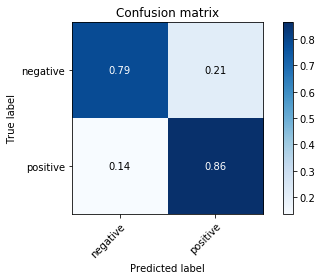

In [143]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### CNN

In [144]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/CNN_100_30_w2v/cnn_100_30_47-0.8050.h5').resolve()

In [145]:
start = time()
model = cnn_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 1.34 secs
              precision    recall  f1-score   support

           0     0.8471    0.8136    0.8300       177
           1     0.8254    0.8571    0.8410       182

    accuracy                         0.8357       359
   macro avg     0.8362    0.8354    0.8355       359
weighted avg     0.8361    0.8357    0.8355       359



Confusion matrix
[[0.81355932 0.18644068]
 [0.14285714 0.85714286]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59cd3e7850>)

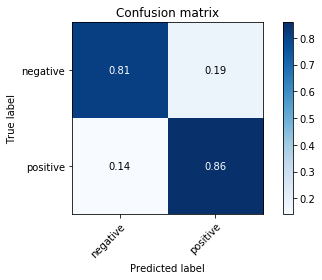

In [146]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### LSTM-CNN

In [66]:
    model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_Conv_100_30_w2v/lstm_conv_100_30_21-0.8122.h5').resolve()

In [67]:
model = lstm_conv_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8509    0.7740    0.8107       177
           1     0.7980    0.8681    0.8316       182

    accuracy                         0.8217       359
   macro avg     0.8245    0.8211    0.8211       359
weighted avg     0.8241    0.8217    0.8213       359



Confusion matrix
[[0.7740113  0.2259887 ]
 [0.13186813 0.86813187]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59dbf1a110>)

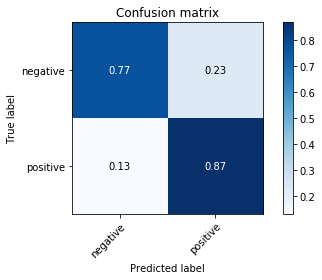

In [68]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

### 50d - no GloVe

In [122]:
input_dim = tokenizer.num_words
embedding_dim = 50

#### LSTM

In [34]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_50_30/lstm_50_30_02-0.8137.h5').resolve()

In [35]:
model = lstm_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8284    0.7910    0.8092       177
           1     0.8053    0.8407    0.8226       182

    accuracy                         0.8162       359
   macro avg     0.8168    0.8158    0.8159       359
weighted avg     0.8167    0.8162    0.8160       359



Confusion matrix
[[0.79096045 0.20903955]
 [0.15934066 0.84065934]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71f3b9bc10>)

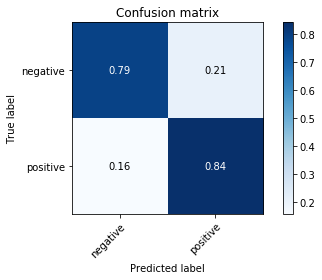

In [36]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### CNN

In [70]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/CNN_50_30_ne/cnn_50_30_03-0.8094.h5').resolve()

In [71]:
model = cnn_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8266    0.8079    0.8171       177
           1     0.8172    0.8352    0.8261       182

    accuracy                         0.8217       359
   macro avg     0.8219    0.8215    0.8216       359
weighted avg     0.8218    0.8217    0.8217       359



Confusion matrix
[[0.8079096  0.1920904 ]
 [0.16483516 0.83516484]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59db6927d0>)

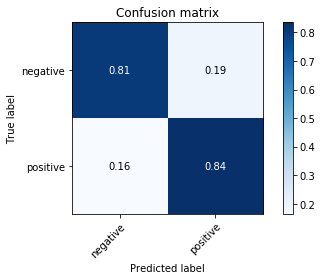

In [72]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### LSTM-CNN

In [73]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_Conv_50_30/lstm_conv_50_30_05-0.8132.h5').resolve()

In [74]:
start = time()
model = lstm_conv_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 1.45 secs
              precision    recall  f1-score   support

           0     0.8443    0.7966    0.8198       177
           1     0.8125    0.8571    0.8342       182

    accuracy                         0.8273       359
   macro avg     0.8284    0.8269    0.8270       359
weighted avg     0.8282    0.8273    0.8271       359



Confusion matrix
[[0.79661017 0.20338983]
 [0.14285714 0.85714286]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59d9e4f650>)

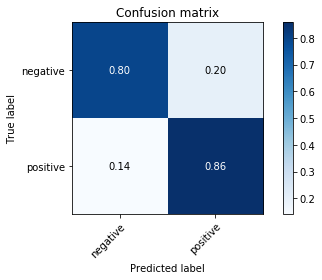

In [75]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

### 100d - no GloVe

In [123]:
embedding_dim = 100

#### LSTM

In [136]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_100_30_ne/lstm_100_30_02-0.8121.h5').resolve()

In [137]:
start = time()
model = lstm_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 1.9 secs
              precision    recall  f1-score   support

           0     0.8494    0.7966    0.8222       177
           1     0.8135    0.8626    0.8373       182

    accuracy                         0.8301       359
   macro avg     0.8314    0.8296    0.8297       359
weighted avg     0.8312    0.8301    0.8299       359



Confusion matrix
[[0.79661017 0.20338983]
 [0.13736264 0.86263736]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59bd3944d0>)

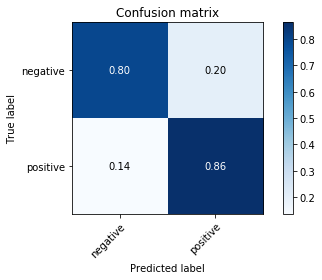

In [138]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### CNN

In [133]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/CNN_100_30_ne/cnn_100_30_03-0.8084.h5').resolve()

In [134]:
start = time()
model = cnn_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 1.1 secs
              precision    recall  f1-score   support

           0     0.8605    0.8362    0.8481       177
           1     0.8449    0.8681    0.8564       182

    accuracy                         0.8524       359
   macro avg     0.8527    0.8521    0.8523       359
weighted avg     0.8526    0.8524    0.8523       359



Confusion matrix
[[0.83615819 0.16384181]
 [0.13186813 0.86813187]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59be3c5950>)

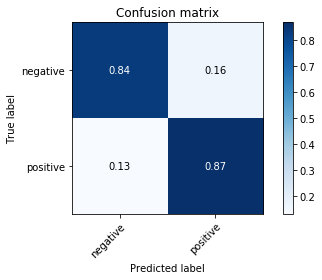

In [135]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### LSTM-CNN

In [83]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_Conv_100_30/lstm_conv_100_30_05-0.8129.h5').resolve()

In [84]:
start = time()
model = lstm_conv_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 1.66 secs
              precision    recall  f1-score   support

           0     0.8519    0.7797    0.8142       177
           1     0.8020    0.8681    0.8338       182

    accuracy                         0.8245       359
   macro avg     0.8269    0.8239    0.8240       359
weighted avg     0.8266    0.8245    0.8241       359



Confusion matrix
[[0.77966102 0.22033898]
 [0.13186813 0.86813187]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59cafec490>)

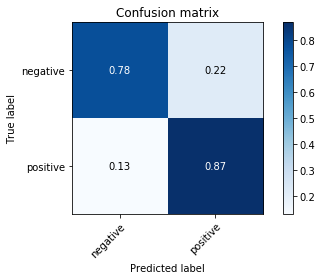

In [85]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)